In [2]:
from copy import copy
from functools import partial
import itertools
import json
from pathlib import Path
import re
import sys
sys.path.append("../src")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.formula.api as smf
from tqdm import tqdm, tqdm_notebook

%matplotlib inline
sns.set(style="whitegrid", context="paper", font_scale=3.5, rc={"lines.linewidth": 2.5})
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

## Data preparation

In [3]:
# Path to decoder results
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")

In [36]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert/models").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = ["_", "SQuAD", "QQP", "MNLI", "SST", "LM", "LM_lmonly", "LM_scrambled", "LM_scrambled_para", "LM_contentonly", "LM_randommask", "LM_pos"]
other_models = ["glove"]

# Models which should appear in the final report figures
report_models = ["SQuAD", "QQP", "MNLI", "SST", "LM", "LM_scrambled", "LM_scrambled_para", "LM_pos", "glove"]
checkpoint_steps = list(range(5,255,5))

# Standard models vs custom models
standard_models = ["LM", "SQuAD", "QQP", "MNLI", "SST", "glove"]
custom_models = ["LM_lmonly", "LM_scrambled", "LM_scrambled_para", "LM_contentonly", "LM_randommask", "LM_pos"]

report_model_sets = [
    ("all", set(report_models)),
    ("standard", set(report_models) & set(standard_models)),
    ("custom", set(report_models) & set(custom_models)),
]

# Describes the particular fine-tuning regime used
finetune_desc = "finetune-250"
target_runs = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [5]:
RENDER_FINAL = True
figure_path = Path("../reports/figures")
figure_path.mkdir(exist_ok=True)

report_hues = dict(zip(sorted(report_models), sns.color_palette()))

### Decoder performance metrics

In [6]:
# Load decoder performance data.
decoding_perfs = util.load_decoding_perfs(decoder_path, glob_prefix="encodings.%s" % finetune_desc)

Loading perf files: 100%|██████████| 38487/38487 [01:47<00:00, 359.34it/s]


In [7]:
# Load base decoder data.
base_perfs = {}
for base_decoder_perf_path in decoder_path.glob("encodings.%s*.csv" % bert_base_model):
    subject, = re.findall(r"-([\w\d]+)\.csv$", base_decoder_perf_path.name)
    perf = pd.read_csv(decoder_path / (base_decoder_perf_path.name.replace("pred.npy", "csv")),
                       usecols=["mse", "r2", "rank_median", "rank_mean", "rank_min", "rank_max"])
    base_perfs["_", 1, 0, subject] = perf

In [8]:
decoding_perfs = \
    pd.concat([decoding_perfs,
               pd.concat(base_perfs, names=["model", "run", "step", "subject"])])

In [9]:
# Load comparison model data.
for other_model in other_models:
    for other_perf_path in tqdm_notebook(decoder_path.glob("encodings.%s-*.csv" % other_model)):
        subject, = re.findall(r"-([\w\d]+)\.csv$", other_perf_path.name)
        perf = pd.read_csv(other_perf_path,
                           usecols=["mse", "r2", "rank_median", "rank_mean", "rank_min", "rank_max"])
        decoding_perfs.loc[other_model, 1, 250, subject] = perf.iloc[0]

### Model performance metrics

In [11]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {}
for model in bert_models:
    print(model)
    
    m_target_runs = [-1] if model == "_" else target_runs
    for target_run in m_target_runs:
        target_run_str = "" if target_run == -1 else "-run%i" % target_run
        
        if model == "_":
            model_dir = bert_path / bert_base_model
        else:
            model_dir = bert_path / ("%s.%s.%s%s" % (finetune_desc, bert_base_model, model, target_run_str))

        try:
            metadata = util.load_bert_finetune_metadata(model_dir, checkpoint_steps)
        except:
            pass
        
        if metadata["steps"]:
            model_metadata[model, target_run] = pd.DataFrame.from_dict(metadata["steps"], orient="index")

model_metadata = pd.concat(model_metadata, names=["model", "run", "step"])

_
Missing training events file in savedir: /home/jgauthie/om2/others/bert/models/uncased_L-12_H-768_A-12
Missing eval events data in savedir: /home/jgauthie/om2/others/bert/models/uncased_L-12_H-768_A-12
SQuAD
QQP
MNLI
SST
LM
LM_lmonly
LM_scrambled
LM_scrambled_para
LM_contentonly
LM_randommask
LM_pos


In [12]:
# SQuAD results need to be loaded separately from manual eval.
if "SQuAD" in bert_models:
    for target_run in tqdm(target_runs, desc="SQuAD run"):
        target_run_str = "" if target_run is None else "-run%i" % target_run
        model_dir = bert_path / ("%s.%s.SQuAD%s" % (finetune_desc, bert_base_model, target_run_str))
        if not model_dir.exists():
            continue

        for checkpoint_step in checkpoint_steps:
            pred_dir = model_dir / "predictions" / str(checkpoint_step)
            try:
                with (pred_dir / "results.json").open() as results_f:
                    results = json.load(results_f)
                model_metadata.loc["SQuAD", target_run, checkpoint_step]["eval_accuracy"] = \
                    results["best_f1"] / 100.
            except:
                print("SQuAD failed:", target_run, checkpoint_step)

SQuAD run:   0%|          | 0/9 [00:00<?, ?it/s]

SQuAD failed: 1 5


SQuAD run:  11%|█         | 1/9 [00:01<00:11,  1.44s/it]

SQuAD failed: 2 5


SQuAD run:  22%|██▏       | 2/9 [00:02<00:10,  1.46s/it]

SQuAD failed: 3 5


SQuAD run:  33%|███▎      | 3/9 [00:04<00:08,  1.41s/it]

SQuAD failed: 4 5


SQuAD run:  44%|████▍     | 4/9 [00:05<00:06,  1.39s/it]

SQuAD failed: 5 135
SQuAD failed: 5 140


SQuAD run:  56%|█████▌    | 5/9 [00:07<00:05,  1.43s/it]

SQuAD failed: 6 5
SQuAD failed: 6 10


SQuAD run:  67%|██████▋   | 6/9 [00:08<00:04,  1.52s/it]

SQuAD failed: 7 5


SQuAD run: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]

SQuAD failed: 8 5
SQuAD failed: 8 10
SQuAD failed: 8 15
SQuAD failed: 8 20
SQuAD failed: 8 25
SQuAD failed: 8 30
SQuAD failed: 8 35
SQuAD failed: 8 40
SQuAD failed: 8 45
SQuAD failed: 8 50
SQuAD failed: 8 55
SQuAD failed: 8 60
SQuAD failed: 8 65
SQuAD failed: 8 70
SQuAD failed: 8 75
SQuAD failed: 8 80
SQuAD failed: 8 85
SQuAD failed: 8 90
SQuAD failed: 8 95
SQuAD failed: 8 100
SQuAD failed: 8 105
SQuAD failed: 8 110
SQuAD failed: 8 115
SQuAD failed: 8 120
SQuAD failed: 8 125
SQuAD failed: 8 130
SQuAD failed: 8 135
SQuAD failed: 8 140
SQuAD failed: 8 145
SQuAD failed: 8 150
SQuAD failed: 8 155
SQuAD failed: 8 160
SQuAD failed: 8 165
SQuAD failed: 8 170
SQuAD failed: 8 175
SQuAD failed: 8 180
SQuAD failed: 8 185
SQuAD failed: 8 190
SQuAD failed: 8 195
SQuAD failed: 8 200
SQuAD failed: 8 205
SQuAD failed: 8 210
SQuAD failed: 8 215
SQuAD failed: 8 220
SQuAD failed: 8 225
SQuAD failed: 8 230
SQuAD failed: 8 235
SQuAD failed: 8 240
SQuAD failed: 8 245
SQuAD failed: 8 250


### Putting it all together

In [13]:
# Join decoding data, post-hoc rank evaluation data, and model training metadata into a single df.
old_index = decoding_perfs.index
df = decoding_perfs.reset_index().join(model_metadata, on=["model", "run", "step"]).set_index(old_index.names)
df.head()

mse        r2  rank_mean  rank_median  rank_min  \
model run step subject                                                         
LM    1   5    M02      0.003455 -0.068181  21.239583          6.0       0.0   
               M04      0.003643 -0.066811  38.765625         14.5       0.0   
               M07      0.003547 -0.067633  28.510417         10.0       0.0   
               M08      0.003630 -0.067629  40.382812         15.0       0.0   
               M09      0.003650 -0.064731  39.598958         14.5       0.0   

                        rank_max  total_global_norms  train_loss  \
model run step subject                                             
LM    1   5    M02         335.0            8.704641    2.580584   
               M04         335.0            8.704641    2.580584   
               M07         361.0            8.704641    2.580584   
               M08         342.0            8.704641    2.580584   
               M09         378.0            8.704641    2.580584   

                        train_loss_norm  eval_accuracy  eval_loss  
model run step subject                                             
LM    1   5    M02                  NaN       0.593933        NaN  
               M04                  NaN       0.593933        NaN  
               M07                  NaN       0.593933        NaN  
               M08                  NaN       0.593933        NaN  
               M09                  NaN       0.593933        NaN

-----------

In [14]:
all_subjects = df.index.get_level_values("subject").unique()
all_subjects

Index(['M02', 'M04', 'M07', 'M08', 'M09', 'M14', 'M15', 'P01'], dtype='object', name='subject')

### Synthetic columns

In [15]:
df["eval_accuracy_delta"] = df.groupby(["model", "run"]).eval_accuracy.transform(lambda xs: xs - xs.iloc[0])
df["eval_accuracy_norm"] = df.groupby(["model", "run"]).eval_accuracy.transform(lambda accs: (accs - accs.min()) / (accs.max() - accs.min()))

In [16]:
def decoding_perf_delta(xs, metric="mse"):
    subject = xs.index[0][3]
    base_metric = df.loc["_", 1, 0, subject][metric]
    return xs - base_metric

df["decoding_mse_delta"] = df.groupby(["model", "run", "subject"]).mse.transform(partial(decoding_perf_delta, metric="mse"))
df["rank_mean_delta"] = df.groupby(["model", "run", "subject"]).rank_mean.transform(partial(decoding_perf_delta, metric="rank_mean"))
df["rank_median_delta"] = df.groupby(["model", "run", "subject"]).rank_median.transform(partial(decoding_perf_delta, metric="rank_median"))

In [17]:
NUM_BINS = 50
def bin(xs):
    if xs.isnull().values.any(): return np.nan
    return pd.cut(xs, np.linspace(xs.min(), xs.max(), NUM_BINS), labels=False)
df["eval_accuracy_bin"] = df.groupby(["model"]).eval_accuracy.transform(bin)
df["decoding_mse_bin"] = df.groupby(["subject"]).decoding_mse_delta.transform(bin)
df["total_global_norms_bin"] = df.groupby(["model"]).total_global_norms.transform(bin)

In [18]:
ROLLING_WINDOW_SIZE = 5
grouped = df.groupby(["model", "run", "subject"])
for col in ["mse", "decoding_mse_delta", "eval_accuracy", "train_loss", "rank_mean", "rank_mean_delta"]:
    df["%s_rolling" % col] = grouped[col].transform(lambda rows: rows.rolling(ROLLING_WINDOW_SIZE, min_periods=1).mean())

In [19]:
df.tail()

mse        r2  rank_mean  rank_median  rank_min  \
model run step subject                                                         
glove 1   250  M08      0.003592 -0.069331  47.283854         21.5       0.0   
               M09      0.003656 -0.069032  55.739583         26.0       0.0   
               M14      0.003736 -0.068638  68.328125         33.0       0.0   
               M15      0.003535 -0.061499  40.890625         17.0       0.0   
               P01      0.003337 -0.064256  24.380208          8.0       0.0   

                        rank_max  total_global_norms  train_loss  \
model run step subject                                             
glove 1   250  M08         379.0                 NaN         NaN   
               M09         375.0                 NaN         NaN   
               M14         371.0                 NaN         NaN   
               M15         380.0                 NaN         NaN   
               P01         285.0                 NaN         NaN   

                        train_loss_norm  eval_accuracy  \
model run step subject                                   
glove 1   250  M08                  NaN            NaN   
               M09                  NaN            NaN   
               M14                  NaN            NaN   
               M15                  NaN            NaN   
               P01                  NaN            NaN   

                                 ...             rank_median_delta  \
model run step subject           ...                                 
glove 1   250  M08               ...                           7.0   
               M09               ...                          11.0   
               M14               ...                           5.5   
               M15               ...                           6.5   
               P01               ...                           1.5   

                        eval_accuracy_bin  decoding_mse_bin  \
model run step subject                                        
glove 1   250  M08                    NaN              13.0   
               M09                    NaN              18.0   
               M14                    NaN              22.0   
               M15                    NaN              11.0   
               P01                    NaN               8.0   

                        total_global_norms_bin  mse_rolling  \
model run step subject                                        
glove 1   250  M08                         NaN     0.003592   
               M09                         NaN     0.003656   
               M14                         NaN     0.003736   
               M15                         NaN     0.003535   
               P01                         NaN     0.003337   

                        decoding_mse_delta_rolling  eval_accuracy_rolling  \
model run step subject                                                      
glove 1   250  M08                       -0.000031                    NaN   
               M09                       -0.000005                    NaN   
               M14                       -0.000013                    NaN   
               M15                       -0.000028                    NaN   
               P01                       -0.000088                    NaN   

                        train_loss_rolling  rank_mean_rolling  \
model run step subject                                          
glove 1   250  M08                     NaN          47.283854   
               M09                     NaN          55.739583   
               M14                     NaN          68.328125   
               M15                     NaN          40.890625   
               P01                     NaN          24.380208   

                        rank_mean_delta_rolling  
model run step subject                           
glove 1   250  M08                    10.263021  
               M09                    14.945313  
             

In [20]:
df.head()

mse        r2  rank_mean  rank_median  rank_min  \
model run step subject                                                         
LM    1   5    M02      0.003455 -0.068181  21.239583          6.0       0.0   
               M04      0.003643 -0.066811  38.765625         14.5       0.0   
               M07      0.003547 -0.067633  28.510417         10.0       0.0   
               M08      0.003630 -0.067629  40.382812         15.0       0.0   
               M09      0.003650 -0.064731  39.598958         14.5       0.0   

                        rank_max  total_global_norms  train_loss  \
model run step subject                                             
LM    1   5    M02         335.0            8.704641    2.580584   
               M04         335.0            8.704641    2.580584   
               M07         361.0            8.704641    2.580584   
               M08         342.0            8.704641    2.580584   
               M09         378.0            8.704641    2.580584   

                        train_loss_norm  eval_accuracy  \
model run step subject                                   
LM    1   5    M02                  NaN       0.593933   
               M04                  NaN       0.593933   
               M07                  NaN       0.593933   
               M08                  NaN       0.593933   
               M09                  NaN       0.593933   

                                 ...             rank_median_delta  \
model run step subject           ...                                 
LM    1   5    M02               ...                          -1.0   
               M04               ...                          -0.5   
               M07               ...                          -0.5   
               M08               ...                           0.5   
               M09               ...                          -0.5   

                        eval_accuracy_bin  decoding_mse_bin  \
model run step subject                                        
LM    1   5    M02                    1.0              14.0   
               M04                    1.0              19.0   
               M07                    1.0              12.0   
               M08                    1.0              17.0   
               M09                    1.0              17.0   

                        total_global_norms_bin  mse_rolling  \
model run step subject                                        
LM    1   5    M02                         NaN     0.003455   
               M04                         NaN     0.003643   
               M07                         NaN     0.003547   
               M08                         NaN     0.003630   
               M09                         NaN     0.003650   

                        decoding_mse_delta_rolling  eval_accuracy_rolling  \
model run step subject                                                      
LM    1   5    M02                       -0.000002               0.593933   
               M04                        0.000011               0.593933   
               M07                       -0.000008               0.593933   
               M08                        0.000007               0.593933   
               M09                       -0.000011               0.593933   

                        train_loss_rolling  rank_mean_rolling  \
model run step subject                                          
LM    1   5    M02                2.580584          21.239583   
               M04                2.580584          38.765625   
               M07                2.580584          28.510417   
               M08                2.580584          40.382812   
               M09                2.580584          39.598958   

                        rank_mean_delta_rolling  
model run step subject                           
LM    1   5    M02                    -0.289062  
               M04                     0.789062  
             

In [21]:
dfi = df.reset_index()

## Model training analysis

Let's verify that each model is not overfitting; if it is overfitting, restrict our analysis to just the region before overfitting begins.

In [22]:
# g = sns.FacetGrid(df.reset_index().melt(id_vars=["model", "run", "step"],
#                                         value_vars=["train_loss_rolling", "eval_accuracy_rolling"]),
#                   row="variable", col="model", sharex=True, sharey=False, height=4)
# g.map(sns.lineplot, "step", "value", "run", ci=None)
# g.add_legend()

In [23]:
%matplotlib agg

if RENDER_FINAL:
    # models which appear on left edge of subfigs in paper
    LEFT_EDGE_MODELS = ["QQP", "LM"]
    
    training_fig_path = figure_path / "training"
    training_fig_path.mkdir(exist_ok=True)
    shared_kwargs = {"legend": False, "ci": None}

    for model in tqdm_notebook(report_models):
        f, (loss_fig, acc_fig) = plt.subplots(2, 1, figsize=(10,15), sharex=True)
        local_data = df.loc[model].reset_index()
        ax = sns.lineplot(data=local_data, x="step", y="train_loss_rolling", hue="run", ax=loss_fig, **shared_kwargs)
        ax.set_ylabel("Training loss\n(rolling window)" if model in LEFT_EDGE_MODELS else "")
        ax.set_xlabel("Training step")
        
        ax = sns.lineplot(data=local_data, x="step", y="eval_accuracy_rolling", hue="run", ax=acc_fig, **shared_kwargs)
        ax.set_ylabel("Validation set accuracy\n(rolling window)" if model in LEFT_EDGE_MODELS else "")
        ax.set_xlabel("Training step")
        
        sns.despine()
        
        plt.tight_layout()
        plt.savefig(training_fig_path / ("%s.pdf" % model))
        plt.close()
%matplotlib inline

## Decoding analyses

In [24]:
MSE_DELTA_LABEL = "$\Delta$(MSE)"
MAR_DELTA_LABEL = "$\Delta$(MAR)"

### Final state analysis

In [37]:
%matplotlib agg

if RENDER_FINAL:
    final_state_fig_path = figure_path / "final_state"
    final_state_fig_path.mkdir(exist_ok=True)
    metrics = [("decoding_mse_delta", MSE_DELTA_LABEL, None, None),
               ("rank_mean_delta", MAR_DELTA_LABEL, None, None),
               ("mse", "Mean squared error", 0.00335, 0.00385),
               ("rank_mean", "Mean average rank", 20, 95)]
    
    for model_set_name, model_set in report_model_sets:
        final_df = dfi[(dfi.step == checkpoint_steps[-1]) & (dfi.model.isin(model_set))]

        for metric, label, ymin, ymax in tqdm_notebook(metrics):
            fig, ax = plt.subplots(figsize=(15, 10))

            # Plot BERT baseline performance.
            if "delta" not in metric:
                ax.axhline(dfi[dfi.model == "_"][metric].mean(), linestyle="--", color="gray")

            sns.barplot(data=final_df, x="model", y=metric,
                        order=final_df.groupby("model")[metric].mean().sort_values().index,
                        palette=report_hues, ax=ax)

            padding = final_df[metric].var() * 0.005
            plt.ylim((ymin or (final_df[metric].min() - padding), ymax or (final_df[metric].max() + padding)))
            plt.xlabel("Model")
            plt.ylabel(label)
            plt.xticks(rotation=45, ha="right")

            plt.tight_layout()
            plt.savefig(final_state_fig_path / (f"{metric}.{model_set_name}.pdf"))
            #plt.close(fig)
        
%matplotlib inline

In [38]:
%matplotlib agg

if RENDER_FINAL:
    final_state_fig_path = figure_path / "final_state_within_subject"
    final_state_fig_path.mkdir(exist_ok=True)
    metrics = [("decoding_mse_delta", MSE_DELTA_LABEL),
               ("rank_mean_delta", MAR_DELTA_LABEL),
               ("mse", "Mean squared error"),
               ("rank_mean", "Mean average rank")]
    
    for model_set_name, model_set in report_model_sets:
        final_df = dfi[(dfi.step == checkpoint_steps[-1]) & (dfi.model.isin(model_set))]

        for metric, label in tqdm_notebook(metrics):
            fig = plt.figure(figsize=(25, 10))
            sns.barplot(data=final_df, x="model", y=metric, hue="subject",
                        order=final_df.groupby("model")[metric].mean().sort_values().index)
            plt.ylabel(label)
            plt.xticks(rotation=30, ha="right")
            plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
            plt.tight_layout()
            plt.savefig(final_state_fig_path / f"{metric}.{model_set_name}.pdf")
            plt.close(fig)
    
%matplotlib inline

### Step analysis

In [27]:
# g = sns.FacetGrid(dfi, col="run", size=6)
# g.map(sns.lineplot, "step", "decoding_mse_delta", "model").add_legend()

# plt.xlabel("Fine-tuning step")
# plt.ylabel(MSE_DELTA_LABEL)

In [28]:
# g = sns.FacetGrid(dfi, col="run", size=6)
# g.map(sns.lineplot, "step", "rank_mean_delta", "model").add_legend()

# plt.xlabel("Fine-tuning step")
# plt.ylabel(MAR_DELTA_LABEL)

Text(0,0.5,'$\\Delta$(MSE)')

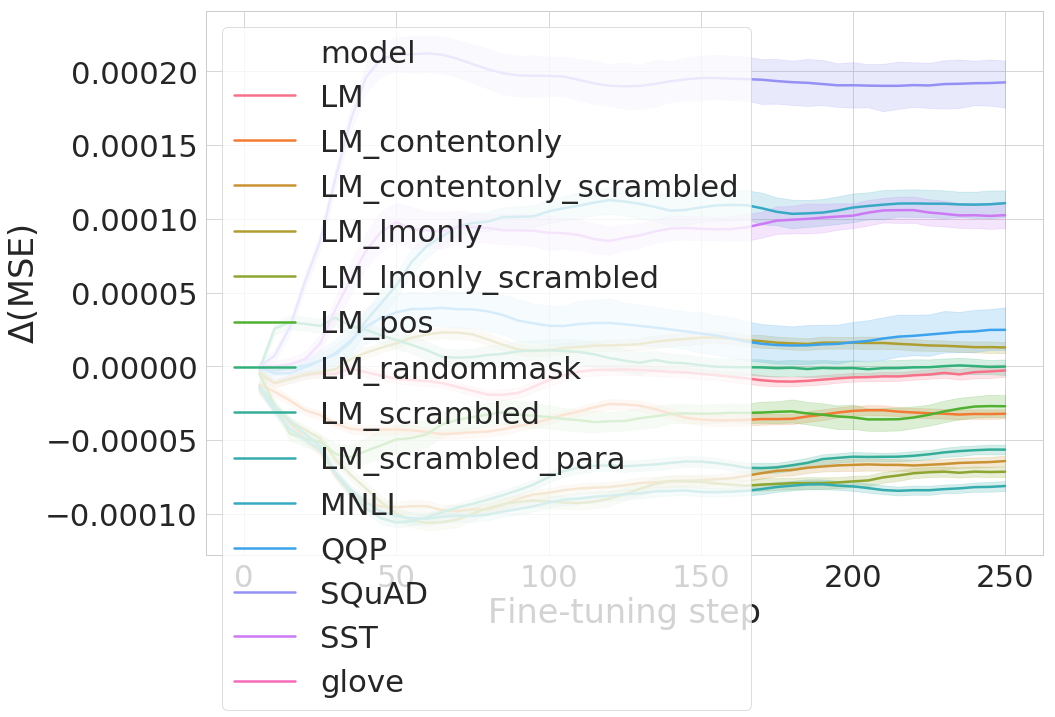

In [29]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=dfi, x="step", y="decoding_mse_delta_rolling", hue="model", ax=ax)

plt.xlabel("Fine-tuning step")
plt.ylabel(MSE_DELTA_LABEL)

KeyboardInterrupt: 

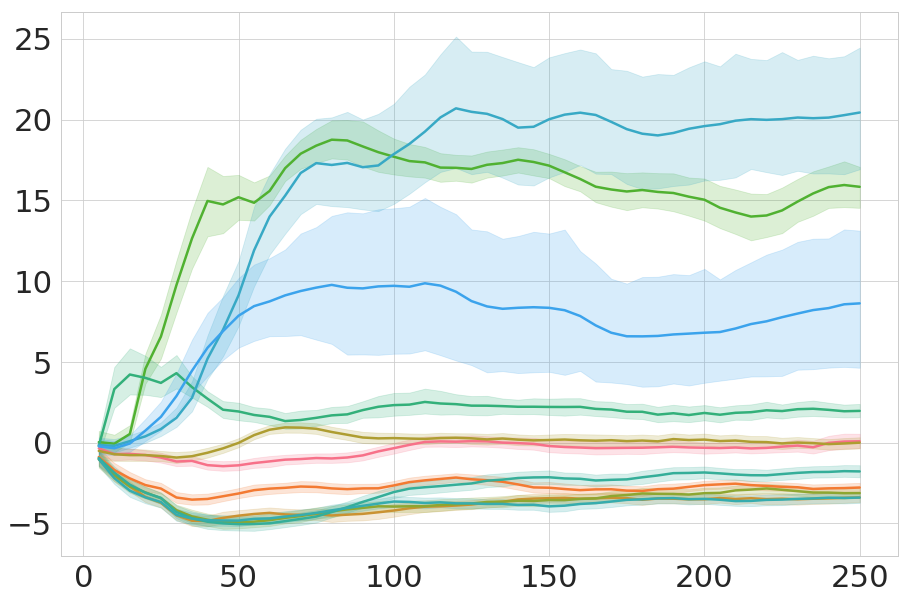

In [30]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=dfi, x="step", y="rank_mean_delta_rolling", hue="model", ax=ax)

plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=dfi[dfi.model.str.startswith("LM")], x="step", y="decoding_mse_delta_rolling", hue="model", ax=ax)

plt.xlabel("Fine-tuning step")
plt.ylabel(MSE_DELTA_LABEL)

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=dfi[dfi.model.str.startswith("LM")], x="step", y="rank_mean_delta_rolling", hue="model", ax=ax)

plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)

In [39]:
%matplotlib agg

if RENDER_FINAL:
    trajectory_fig_dir = figure_path / "trajectories"
    trajectory_fig_dir.mkdir(exist_ok=True)
    metrics = [("decoding_mse_delta", MSE_DELTA_LABEL),
               ("rank_mean_delta", MAR_DELTA_LABEL),
               ("decoding_mse_delta_rolling", MSE_DELTA_LABEL),
               ("rank_mean_delta_rolling", MAR_DELTA_LABEL)]

    for model_set_name, model_set in report_model_sets:
        for metric, label in tqdm_notebook(metrics):
            fig = plt.figure(figsize=(18, 10))
            sns.lineplot(data=dfi[dfi.model.isin(model_set) & (~dfi.model.isin(other_models))],
                         x="step", y=metric, hue="model", palette=report_hues)
            plt.xlim((0, checkpoint_steps[-1]))
            plt.xlabel("Fine-tuning step")
            plt.ylabel(label)
            plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.savefig(trajectory_fig_dir / f"{metric}.{model_set_name}.pdf")
            plt.close(fig)
    
%matplotlib inline

In [ ]:
# g = sns.FacetGrid(dfi[dfi.model != "_"], col="model", row="run", size=6)
# g.map(sns.lineplot, "step", "decoding_mse_delta", "subject", ci=None).add_legend()

In [ ]:
# g = sns.FacetGrid(dfi, col="model", row="run", size=6)
# g.map(sns.lineplot, "step", "rank_median_delta", "subject", ci=None).add_legend()

### Gradient norm analysis

In [ ]:
# f, ax = plt.subplots(figsize=(10, 8))
# sns.lineplot(data=dfi, y="decoding_mse_delta", x="total_global_norms_bin", hue="model", ax=ax)
# ax.set_title("Decoding performance delta vs. binned total global gradient norm")
# ax.set_xlabel("Cumulative global gradient norm bin")
# ax.set_ylabel(MSE_DELTA_LABEL)

In [ ]:
#g = sns.FacetGrid(dfi, col="model", row="run", size=6, sharex=False, sharey=True)
#g.map(sns.lineplot, "total_global_norms", "decoding_mse_delta", "subject", ci=None).add_legend()

### Eval accuracy analysis

In [ ]:
#g = sns.FacetGrid(dfi, col="model", row="run", sharex=False, sharey=True, size=7)
#g.map(sns.lineplot, "eval_accuracy", "decoding_mse_delta", "subject", ci=None).add_legend()

## Per-subject analysis

In [ ]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi[dfi.step == checkpoint_steps[-1]].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.mean()).stack()).reset_index()
sns.barplot(data=dff, x="model", hue="subject", y=0, ax=ax)
plt.title("subject final decoding mse delta, averaging across runs")

In [ ]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi[dfi.step == checkpoint_steps[-1]].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").rank_mean_delta.mean()).stack()).reset_index()
sns.barplot(data=dff, x="model", hue="subject", y=0, ax=ax)
plt.title("subject final rank mean delta, averaging across runs")

In [ ]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.max()).stack()).reset_index()
sns.violinplot(data=dff, x="subject", y=0)
sns.stripplot(data=dff, x="subject", y=0, edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject max decoding mse delta, averaging across models and runs")

In [ ]:
f, ax = plt.subplots(figsize=(14, 9))
dff = pd.DataFrame(dfi.groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mse_delta.min()).stack()).reset_index()
sns.violinplot(data=dff, x="subject", y=0)
sns.stripplot(data=dff, x="subject", y=0, edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject min decoding mse delta, averaging across models and runs")

## Statistical analyses

First, some data prep for comparing final vs. start states:

In [ ]:
perf_comp = df.query("step == %i" % checkpoint_steps[-1]).reset_index(level="step", drop=True).sort_index()
# Join data from baseline
perf_comp = perf_comp.join(df.loc["_", 1, 0].rename(columns=lambda c: "start_%s" % c))
perf_comp = perf_comp.join(df.loc["glove", 1, 250].rename(columns=lambda c: "glove_%s" % c))
perf_comp.head()

In [ ]:
(perf_comp.mse - perf_comp.start_mse).plot.hist()

In [ ]:
perf_compi = perf_comp.reset_index()

Quantitative tests:
 
1. for any GLUE task g, MSE(g after 250) > MSE(LM)
2. for any LM_scrambled_para task t, MSE(t after 250) < MSE(LM)
3. for any GLUE task g, MAR(g after 250) > MAR(LM)
4. for any LM_scrambled_para task t, MAR(t after 250) < MAR(LM)
5. MSE(LM after 250) =~ MSE(LM)
6. MAR(LM after 250) =~ MSE(LM)
7. for any LM_scrambled_para task t, MSE(t after 250) < MSE(glove)
8. for any LM_scrambled_para task t, MAR(t after 250) < MAR(glove)
9. for any LM_pos task t, MSE(t after 250) > MSE(LM)
10. for any LM_pos task t, MAR(t after 250) > MAR(LM)

### test 1

In [ ]:
sample = perf_compi[~perf_compi.model.str.startswith(("_", "LM"))]

In [ ]:
sample.mse.hist()

In [ ]:
sample.start_mse.hist()

In [ ]:
st.ttest_rel(sample.mse, sample.start_mse)

### test 2

In [ ]:
sample = perf_compi[perf_compi.model == "LM_scrambled_para"]

In [ ]:
sample.mse.hist()

In [ ]:
sample.start_mse.hist()

In [ ]:
st.ttest_rel(sample.mse, sample.start_mse)

### test 3

In [ ]:
sample = perf_compi[~perf_compi.model.str.startswith(("_", "LM"))]

In [ ]:
sample.rank_mean.hist()

In [ ]:
sample.start_rank_mean.hist()

In [ ]:
st.ttest_rel(sample.rank_mean, sample.start_rank_mean)

### test 4

In [ ]:
sample = perf_compi[perf_compi.model == "LM_scrambled_para"]

In [ ]:
sample.rank_mean.hist()

In [ ]:
sample.start_rank_mean.hist()

In [ ]:
st.ttest_rel(sample.rank_mean, sample.start_rank_mean)

### test 5

In [ ]:
sample = perf_compi[perf_compi.model == "LM"]

In [ ]:
sample.mse.hist()

In [ ]:
sample.start_mse.hist()

In [ ]:
st.ttest_rel(sample.mse, sample.start_mse)

### test 6

In [ ]:
sample = perf_compi[perf_compi.model == "LM"]

In [ ]:
sample.rank_mean.hist()

In [ ]:
sample.start_rank_mean.hist()

In [ ]:
st.ttest_rel(sample.rank_mean, sample.start_rank_mean)

### test 7

In [ ]:
sample = perf_compi[perf_compi.model == "LM_scrambled_para"]

In [ ]:
sample.mse.hist()

In [ ]:
sample.glove_mse.hist()

In [ ]:
st.ttest_rel(sample.mse, sample.glove_mse)

### test 8

In [ ]:
sample = perf_compi[perf_compi.model == "LM_scrambled_para"]

In [ ]:
sample.rank_mean.hist()

In [ ]:
sample.glove_rank_mean.hist()

In [ ]:
st.ttest_rel(sample.rank_mean, sample.glove_rank_mean)

### test 9

In [ ]:
sample = perf_compi[perf_compi.model == "LM_pos"]

In [ ]:
sample.mse.hist()

In [ ]:
sample.start_mse.hist()

In [ ]:
st.ttest_rel(sample.mse, sample.start_mse)

In [ ]:
f = plt.figure(figsize=(20,20))
sns.barplot(data=pd.melt(sample, id_vars=["subject"], value_vars=["mse", "start_mse"]),
            x="subject", y="value", hue="variable")
plt.ylim((0.0033, 0.0038))

### test 10

In [ ]:
sample = perf_compi[perf_compi.model == "LM_pos"]

In [ ]:
sample.rank_mean.hist()

In [ ]:
sample.start_rank_mean.hist()

In [ ]:
st.ttest_rel(sample.rank_mean, sample.start_rank_mean)